In [123]:
from pyawd import VectorAcousticWaveDataset2D, VectorAcousticWaveDataset3D
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from time import time
import torch
from torchinfo import summary
import tsfresh
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
import pandas as pd

torch.manual_seed(0)
sns.set_theme()

In [2]:
device = 'cpu'
torch.set_default_device(device)

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    def __len__(self):
        return len(self.X)

In [93]:
train_dataset = VectorAcousticWaveDataset2D.load("../../../local/datasets/AWD/train2D")
train_dataset._display_velocity_model = True
X = np.load("../../../local/datasets/AWD/train2D_interrogators_data.npy")
X = X[:, 0, :, :, :]
Y = np.load("../../../local/datasets/AWD/train2D_epicenters.npy")
test_dataset = VectorAcousticWaveDataset2D.load("../../../local/datasets/AWD/test2D")
test_dataset._display_velocity_model = True
X_test = np.load("../../../local/datasets/AWD/test2D_interrogators_data.npy")
X_test = X_test[:, 0, :, :, :]
Y_test = np.load("../../../local/datasets/AWD/test2D_epicenters.npy")

In [95]:
print(X.shape)

(1000, 2, 2, 1000)


In [108]:
def make_df(X):
    a = []
    b = []
    c = []
    d = []
    e = []
    f = []
    for i in range(X.shape[0]):
        for j in range(X.shape[-1]):
            a.append(i)
            b.append(j*train_dataset.ddt)
            c.append(X[i, 0, 0, j])
            d.append(X[i, 0, 1, j])
            e.append(X[i, 1, 0, j])
            f.append(X[i, 1, 1, j])
    df = pd.DataFrame()
    df["id"] = a
    df["time"] = b
    df["x0"] = c
    df["y0"] = d
    df["x1"] = e
    df["y1"] = f
    return df

In [109]:
df, df_test = make_df(X), make_df(X_test)

In [124]:
X_features = tsfresh.extract_features(df, column_id="id", column_sort="time", 
                                      default_fc_parameters=EfficientFCParameters()).dropna(axis=1)

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.39s/it]


In [125]:
X_test_features = tsfresh.extract_features(df_test, column_id="id", column_sort="time", 
                                      default_fc_parameters=EfficientFCParameters()).dropna(axis=1)

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.85it/s]


In [136]:
X_features

,x0__variance_larger_than_standard_deviation,x0__has_duplicate_max,x0__has_duplicate_min,x0__has_duplicate,x0__sum_values,x0__abs_energy,x0__mean_abs_change,x0__mean_change,x0__mean_second_derivative_central,x0__median,...,y1__fourier_entropy__bins_3,y1__fourier_entropy__bins_5,y1__fourier_entropy__bins_10,y1__fourier_entropy__bins_100,y1__permutation_entropy__dimension_3__tau_1,y1__permutation_entropy__dimension_4__tau_1,y1__permutation_entropy__dimension_5__tau_1,y1__permutation_entropy__dimension_6__tau_1,y1__permutation_entropy__dimension_7__tau_1,y1__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,0.221389,0.000146,0.000008,1.881239e-07,-5.285466e-09,0.000242,...,0.090729,0.090729,0.090729,0.215617,0.862379,1.036231,1.218237,1.405412,1.599964,0.003579
1,0.0,0.0,0.0,0.0,-0.035083,0.000094,0.000006,-9.355353e-07,-5.914598e-09,-0.000035,...,0.125256,0.125256,0.170467,0.226363,0.827738,0.968362,1.111004,1.256516,1.404528,0.005821
2,0.0,0.0,0.0,0.0,-0.078853,0.000088,0.000011,-1.933331e-07,-3.861321e-09,-0.000044,...,0.090729,0.136002,0.181214,0.226363,0.801196,0.910212,1.018980,1.130518,1.241791,0.000638
3,0.0,0.0,0.0,0.0,-0.093181,0.000084,0.000007,-7.946764e-08,1.026540e-10,-0.000086,...,0.090729,0.170467,0.170467,0.226363,0.803738,0.915620,1.029776,1.148464,1.269424,0.001737
4,0.0,0.0,0.0,0.0,-0.077751,0.002476,0.000024,-1.348594e-06,3.610024e-09,0.000022,...,0.090729,0.125256,0.125256,0.181214,0.799839,0.909328,1.020876,1.137199,1.251370,0.001954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,5.987473,0.081666,0.000032,1.444552e-05,1.717152e-08,0.002203,...,0.125256,0.125256,0.136002,0.260704,0.878667,1.074271,1.276692,1.482963,1.690069,0.002851
996,0.0,0.0,0.0,0.0,-0.035984,0.000086,0.000011,8.475220e-08,7.538547e-10,-0.000035,...,0.125256,0.204871,0.215617,0.271451,0.832788,0.975893,1.118449,1.263458,1.412679,0.006907
997,0.0,0.0,0.0,0.0,-0.117748,0.000053,0.000008,-5.937707e-08,8.131565e-09,-0.000151,...,0.190068,0.249958,0.316475,0.406332,0.920133,1.167775,1.423988,1.672103,1.926134,0.001253
998,0.0,0.0,0.0,0.0,0.160807,0.000218,0.000016,2.318600e-07,9.975552e-09,0.000115,...,0.110453,0.125256,0.170467,0.316475,0.868373,1.043442,1.220722,1.400048,1.585766,0.002848


In [126]:
d = []
for i in range(10):
    d.append([])
    for j in X_0_features.columns:
        d[-1].append(X_0_features[j][i])
    for j in X_1_features.columns:
        d[-1].append(X_1_features[j][i])
d = np.array(d, dtype=np.float32)

In [127]:
d2 = []
for i in range(10):
    d2.append([])
    for j in X_0_test_features.columns:
        d2[-1].append(X_0_test_features[j][i])
    for j in X_0_test_features.columns:
        d2[-1].append(X_1_test_features[j][i])
d2 = np.array(d2, dtype=np.float32)

In [128]:
train = CustomDataset(d, Y)
train_loader = torch.utils.data.DataLoader(train, batch_size=10)

test = CustomDataset(d2, Y_test)
test_loader = torch.utils.data.DataLoader(test, batch_size=10)

In [129]:
def NMSELoss(y, y_hat):
    return np.square(np.subtract(y, y_hat)).mean()/np.var(y)

In [130]:
def train_loop(loader, model, loss_fn, optimizer, scheduler):
    model.train()
    for x, y in loader:
        pred = model(x)
        loss = loss_fn(pred.squeeze(1), y.squeeze(1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()

def test_loop(model, loader):
    model.eval()
    loss = 0
    for x, y in loader:
        pred = model(x)
        loss += loss_fn(pred.squeeze(1), y.squeeze(1)).item()
    return loss/len(X)      

In [131]:
class FFN(torch.nn.Module):
    def __init__(self):
        super(FFN, self).__init__()

        self.linear1 = torch.nn.Linear(d.shape[-1], 40)
        self.activation = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(40, 10)
        self.flatten = torch.nn.Flatten()
        self.linear3 = torch.nn.Linear(10, 2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.flatten(x)
        x = self.linear3(x)
        x = self.activation(x)
        return x.double()

model = FFN()
learning_rate = 5e-5
epochs = 15000
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)
losses = []

In [132]:
summary(model)

Layer (type:depth-idx)                   Param #
FFN                                      --
├─Linear: 1-1                            2,520
├─Tanh: 1-2                              --
├─Linear: 1-3                            410
├─Flatten: 1-4                           --
├─Linear: 1-5                            22
Total params: 2,952
Trainable params: 2,952
Non-trainable params: 0

In [133]:
t = time()
for e in (pbar := tqdm(range(epochs))):
    train_loop(train_loader, model, loss_fn, optimizer, scheduler)
    losses.append(test_loop(model, test_loader))
    pbar.set_description("Loss: " + str(losses[-1])[:8])
t = time()-t

  0%|          | 0/15000 [00:00<?, ?it/s]

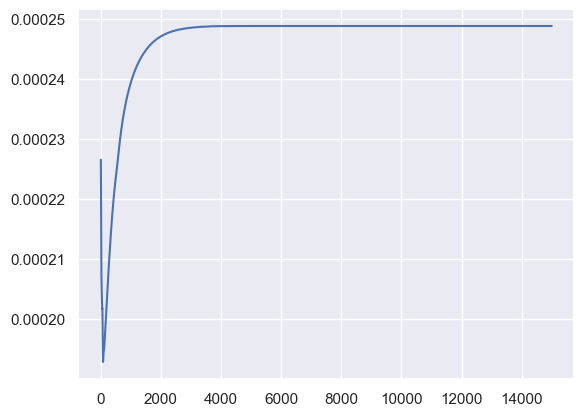

In [134]:
plt.plot(losses)
plt.savefig("../Results/FFN_features_learning.jpg", dpi=250)

NMSE: 1.2999607191780773


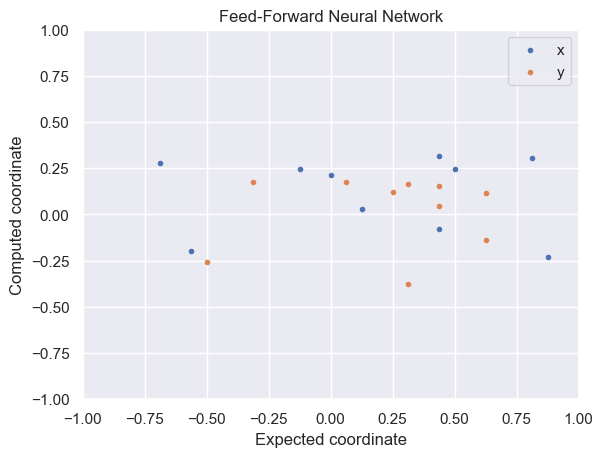

In [135]:
y_test = np.array([(i[0].item(), i[1].item()) for i in Y_test])
y_hat = np.array([model.forward(torch.Tensor(i).unsqueeze(0)).detach().numpy() for i in d2])
y_hat = np.array([(i[:, 0].item(), i[:, 1].item()) for i in y_hat])
nmse = NMSELoss(y_test[:10], y_hat)
print("NMSE:", nmse)
plt.scatter(y_test[:10, 0], y_hat[:, 0], marker='.')
plt.scatter(y_test[:10, 1], y_hat[:, 1], marker='.')
plt.legend(["x", "y"])
plt.xlabel("Expected coordinate")
plt.ylabel("Computed coordinate")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Feed-Forward Neural Network")
plt.savefig("../Results/FFN_features.jpg", dpi=250)

In [91]:
with open("../Results/results.csv", 'a') as f:
    f.write("FNN_features" + "," + str(nmse)[:7] + "," + str(t)[:7] + "," + str(nmse*t)[:7] + "\n")

In [92]:
i = 0
print("Expected epicenter:", test_dataset.get_epicenter(i))
print("\t- FFN on tsfeatures:\t\t", y_hat[i])

Expected epicenter: [0.     0.4375]
	- FFN on tsfeatures:		 [-0.08824163  0.01794028]
